# Final Project: Phase 1

For this phase I was planning on having the algorithm in the paper implemented and tested. I was not able to make it to this point though. I was able to get some training and test data from the paper. Their was one dataset that the only place I found to download it has a restriction of not being able to be used for student projects. 

I was able to implement the Histogram Of Oriented Gradients (HOG) feature extraction. I did it how the paper said to do hopefully I implemented it correctly.
I first took the square root of each pixel value in the image. Then I calculated the Gradient of x and y. I did this by using two nested loops to go through each pixel and calculate the central differences. I then calculated the magnitude and angle of the gradient. 
I then divided the image into 8x8 cells and looped through these cells and added up the gradient magnitude contributions based on ther orientation.
I then normalized the blocks by dividing it by the square root of the sum of squares of its valus
Then I flattened it into a 1d array and used that as the feature vector.


I was also able to some preprocessing of the images and get them into the right image sizes. For that one I used opencv's CascadeClassifier to detect the faces which the basic one worked sometimes but to get more faces cropped properly I used YOLO3 to test if it cropped an actual face. I was having issues where it would crop the wrong part of the image. I used YOLO3 to test this and if it didn't detect a face it would use a different classifier xml setting to detect the face. I got allot better performance with this method.

In [2]:
# imports
import cv2
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import svm


cwd = os.getcwd()


## Preprocessing

### Datasets used
* https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition
*https://www.kaggle.com/datasets/davilsena/ckdataset



### Unable to use Dataset
Not able to use the JAFFE dataset due to restrictions on the dataset. Including the restriction of not being able to be used for homework, undergraduate projects and course projects. Unless there is another way to access it but I wasn't able to find any other way to access it.
https://zenodo.org/records/3451524



## CK+ Dataset

0: anger
1: disgust
2: fear
3: happy
4: sad
5: surprise
6: neutral
7: contempt

   emotion                                             pixels     Usage
0        6  36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...  Training
1        6  88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...  Training
2        6  9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...  Training
3        6  104 106 108 104 95 50 60 61 58 83 126 133 139 ...  Training
4        6  68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...  Training
test
6
img shape:  2304
size: 48 x 48


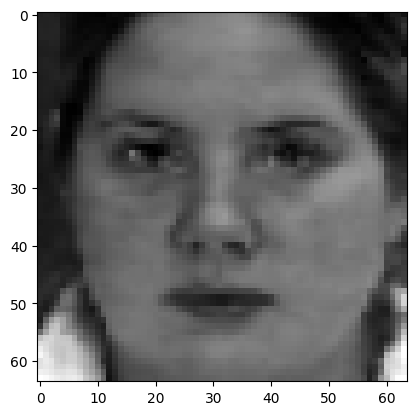

img is gray scale:  True


In [3]:
# https://www.kaggle.com/datasets/davilsena/ckdataset

# load in datasets
# load in the ckextneded.csv file
ckplus_dataset = pd.read_csv(cwd + '/datasets/ckextended.csv')
print(ckplus_dataset.head())
print("test")
print(ckplus_dataset.iloc[0, 0])

# display the first image in the dataset by getting the data in the first row of the second column
# and reshaping it to 48x48
img = ckplus_dataset.iloc[0, 1]
img = img.split(' ')
img = np.array(img, dtype='float32')
print("img shape: ", img.shape[0])
size = int(np.sqrt(img.shape[0]))
print(f"size: {size} x {size}")
img = img.reshape((size, size))
# upscale image to 64x64
img = cv2.resize(img, (64, 64))
plt.imshow(img, cmap='gray')
plt.show()

# check if img is grey scale
print("img is gray scale: ", img.ndim == 2)

# if ckplus_dataset row in the 3rd column is training, then the image is for training, else it is for testing
# create a list of training and testing images
ckplus_images = []
ckplus_labels = []

for i in range(0, ckplus_dataset.shape[0]):
    img = ckplus_dataset.iloc[i, 1]
    img = img.split(' ')
    img = np.array(img, dtype='float32')
    size = int(np.sqrt(img.shape[0]))
    img = img.reshape((size, size))
    img = cv2.resize(img, (64, 64))
    ckplus_images.append(img)
    ckplus_labels.append(ckplus_dataset.iloc[i, 0])

ckplus_dict = {
    'images': ckplus_images,
    'labels': ckplus_labels
}



## From Kaggle tapakah68/facial-emotion-recognition Dataset and preprocessing

In [3]:
def crop_using_viola_johns_algorithm(img, classifier = 'haarcascade_frontalface_default.xml'):
    # load in the haar cascade classifier
    face_cascade = cv2.CascadeClassifier(cwd +'/' +classifier)

    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # detect the faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # draw a rectangle around the face
    for (x, y, w, h) in faces:
        # crop the image
        img = img[y:y+h, x:x+w]
        # resize the image to 48x48
        img = cv2.resize(img, (64, 64))
        # return the image
        return img
    
# croped_image = crop_using_viola_johns_algorithm(cv2.imread(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/0/Anger.jpg'))
# test the function
# cv2.imwrite(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/0/Anger_cropped.jpg', croped_image.astype(np.uint8))


In [4]:
#load YOLOv3 weights and config file
net = cv2.dnn.readNet(cwd + '/yolov3.weights', cwd + '/yolov3.cfg')

with open(cwd + '/coco.names', 'r') as f:
    classes = f.read().strip().split('\n')
def alternative_face_detector(img):
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward()
    layer_names = net.getUnconnectedOutLayersNames()
    detections = net.forward(layer_names)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5 and classes[classID] == "person":
                return True
    return False



In [5]:
# https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition

# crop images if they arent' already cropped

if (os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images') == []):

    classifiers = ['haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml','haarcascade_profileface.xml']

    # go through the folders in the dataset/kaggle-facial-emotional-recognition-dataset 
    for folder in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images'):
        for img_name in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/' + folder):
            img = cv2.imread(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/' + folder + '/' + img_name)
            cropped_image = crop_using_viola_johns_algorithm(img)
            if cropped_image is None:
                print("no face detected")
                break
            if cropped_image is None:
                print("no face detected")
                break
            if alternative_face_detector(cropped_image) == False:
                for classifier in classifiers:
                    cropped_image = crop_using_viola_johns_algorithm(img, classifier)
                    if cropped_image is None:
                        break
                    if alternative_face_detector(cropped_image) == True:
                        break
                
            if cropped_image is None:
                print("no face detected")
                break
            

            # save the image
            # if folder doesn't exist, create it
            if not os.path.exists(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images'):
                os.makedirs(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images')
            if not os.path.exists(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder):
                os.makedirs(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder)
            

                    # convert the image to grayscale
            
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder + '/' + img_name, cropped_image)
        # go through the images in the folder
    

   


In [6]:
def get_number_label_for_string(label):
    if label == 'Anger':
        return 0
    elif label == 'Disgust':
        return 1
    elif label == 'Fear':
        return 2
    elif label == 'Happy':
        return 3
    elif label == 'Sad':
        return 4
    elif label == 'Surprised':
        return 5
    elif label == 'Neutral':
        return 6
    elif label == 'Contempt':
        return 7
    else:
        return -1

In [7]:
# load in the cropped images
# create a list of training and testing images

kaggle_images = []
kaggle_labels = []

for folder in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images'):
    for img_name in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder):
        img = cv2.imread(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder + '/' + img_name)
        if img is None:
            print("img is none")
            break
        kaggle_images.append(img)
        # print(img_name)
        # print(img_name.split('.')[0])
        kaggle_labels.append(get_number_label_for_string(img_name.split('.')[0]))
        
print("kaggle images: ", len(kaggle_images))
print("kaggle labels: ", len(kaggle_labels))

kaggle_dict = {
    'images': kaggle_images,
    'labels': kaggle_labels
}

        

kaggle images:  125
kaggle labels:  125


In [8]:
    # calc hog features using cv2.HOGDescriptor
def generate_hog_features(image):
    # hog = cv2.HOGDescriptor()
    # # hog_features = hog.compute(image)
     image = np.sqrt(image)

     G_x = np.zeros_like(image, dtype=np.float32)
     G_y = np.zeros_like(image, dtype=np.float32)

     for y in range(1, image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            G_x[y, x] = image[y, x-1] - image[y, x+1]
            G_y[y, x] = image[y-1, x] - image[y+1, x]
    
     G = np.sqrt(np.square(G_x) + np.square(G_y))
     theta = np.arctan(G_y, G_x)

     # divide the image into 8x8 cells
     cells = np.zeros((8, 8, 8), dtype=np.float32)
     # for each cell create a local 1-D histogram of gradient orientations that is sorted into 9 angular bins according to their gradient orientation evenly distributed over 0 to 180 degrees
     for y in range(0, image.shape[0] - 8, 8):
        for x in range(0, image.shape[1] - 8, 8):
            for i in range(8):
                for j in range(8):
                    cells[i, j, int(theta[y+i, x+j] / 20)] += G[y+i, x+j]

     # divide the cells within each angular bin divided into blocks with 3x3 cell in size
     # for each block, normalize the histogram using L2-normalization approach
     hog_features = []
     for y in range(0, 6):
        for x in range(0, 6):
            block = cells[y:y+3, x:x+3].flatten()
            block /= np.sqrt(np.sum(np.square(block)) + 1e-5)
            hog_features.extend(block)
     hog_features = np.array(hog_features)

     hog_features = hog_features.flatten()
     return hog_features

In [9]:
def process_fold(train, test, classifier):
    # https://www.researchgate.net/publication/221364666_Feature_reduction_using_Cuttlefish_Optimization_Algorithm
    #CFA algorithm begins by keeping the feature locations (indices) of a particular dataset in a RankedArray list as follows: RankedArray = [0, 1, 2, …, L − 1], where L represents the feature size. 
    #After that, it initializes a population (P) with N random solutions, so that each solution Pi is linked with two subsets: SelectedFeatures and UnselectedFeatures, where SelectedFeatures ⊂ RankedArray, UnselectedFeatures ⊂ RankedArray, and SelectedFeatures ⋂ UnselectedFeatures = Ø

    # ranked_list variable has the indices of the features in the dataset from 0 to image feature size - 1
    ranked_list = np.arange(train['images'][0].shape[0])

    # train and test has following structure {'images': [], 'labels': []}

    # solution has the following structure list of solution dictionaries which contain the indices of the selected and unselected features
    solutions = []
    N = random.randint(1, train['images'][0].shape[0])
    for random_solution in range(0, N):
        # randomly select the indices of the features
        indices_for_selected_features = np.random.choice(ranked_list, N)
        # using the indices_for_selected_features take the indices and put those features aat those indices in the selected_features array
        selected_image_features_indices = [indices_for_selected_features]
        unselected_image_features_indices = np.setdiff1d(ranked_list, selected_image_features_indices)
        solution = {
            'selected_features_indices': selected_image_features_indices,
            'unselected_features_indices': unselected_image_features_indices,
        }
        solutions.append(solution)


    # go through each solution in the solutions list and calculate the goodness of the solution
    solutions_with_goodness = []
    for solution in solutions:
        # calculate the goodness of the solution
        # goodness = 1 / (1 + error)
        # error = 1 - accuracy
        # accuracy = svm.score(features[solution[0]], features[solution[1]])

        # get the features at the selected_features_indices
        train_images_with_selected_features =[]
        for i in range(0, train['images'].shape[0]):
            train_images_with_selected_features.append(train['images'][i][solution['selected_features_indices']])
        test_images_with_selected_features = []
        for i in range(0, test['images'].shape[0]):
            test_images_with_selected_features.append(test['images'][i][solution['selected_features_indices']])

        classifier.fit(train_images_with_selected_features, train['labels'])
        solution['goodness'] = 1 / (1 + (1 - svm.score(train['images'][solution['selected_features_indices']], train['labels'])))
        # TODO maybe change this to use the test accuracy for the goodness
        test_accuracy = svm.score(test_images_with_selected_features, test['labels'])
        print("test accuracy: ", test_accuracy)
        solutions_with_goodness.append(solution)

    # sort the solutions_with_goodness list in descending order of goodness
    solutions_with_goodness.sort(key=lambda x: x['goodness'], reverse=True)

    best_solution = solutions_with_goodness[0]

    # randomly delete 10% of the features from the selected_features_indices
    best_solution['selected_features_indices'] = np.random.choice(best_solution['selected_features_indices'], int(best_solution['selected_features_indices'].shape[0] * 0.9))
    
    # while the stopping criteria is not met, the algorithm performs the following steps:   
    stoping_criteria = 0
    while stoping_criteria !=100:
        # calculat the CFA of each solution within the population_of_solutions
        # for each solution within the population_of_solutions, calculate the CFA
        K = random.randint(0,N/2)
        for i in range(0, K-1):
            r = random.randint(0,solutions_with_goodness[i]["selected_image_features_indices"].shape[0]-1)
            v = solutions_with_goodness[i]["selected_image_features_indices"] - r
            reflection = random.sample(solutions_with_goodness[i]["selected_image_features_indices"], r)
            visibility = random.sample(solutions_with_goodness[i]["unselected_features_indices"], v)
            # new subset union of reflection and visibility
            newSubset = reflection + visibility
            # evaluate new subset using the svm
            # get the features at the selected_features_indices
            train_images_with_selected_features =[]
            for i in range(0, train['images'].shape[0]):
                train_images_with_selected_features.append(train['images'][i][newSubset])
            test_images_with_selected_features = []
            for i in range(0, test['images'].shape[0]):
                test_images_with_selected_features.append(test['images'][i][newSubset])

            classifier.fit(train_images_with_selected_features, train['labels'])
            goodness = 1 / (1 + (1 - svm.score(train['images'][newSubset], train['labels'])))
            # TODO maybe change this to use the test accuracy for the goodness
            test_accuracy = svm.score(test_images_with_selected_features, test['labels'])
            print("test accuracy: ", test_accuracy)
            if goodness > solutions_with_goodness[i]['goodness']:
                solutions_with_goodness[i]['goodness'] = goodness
                solutions_with_goodness[i]['selected_features_indices'] = newSubset
                solutions_with_goodness[i]['unselected_features_indices'] = np.setdiff1d(ranked_list, newSubset)
            if goodness > best_solution['goodness']:
                best_solution = solutions_with_goodness[i]
        
        newSubset = best_solution
        T = 5
        for i in range(0, T-1):
            # randomly exchange 10% of the features between the selected and unselected features of the newSubset
            newSubset = np.random.choice(newSubset['selected_features_indices'], int(newSubset['selected_features_indices'].shape[0] * 0.9))

            # evaluate new subset using the svm
            # get the features at the selected_features_indices
            train_images_with_selected_features =[]
            for i in range(0, train['images'].shape[0]):
                train_images_with_selected_features.append(train['images'][i][newSubset])
            test_images_with_selected_features = []
            for i in range(0, test['images'].shape[0]):
                test_images_with_selected_features.append(test['images'][i][newSubset])

            classifier.fit(train_images_with_selected_features, train['labels'])
            goodness = 1 / (1 + (1 - svm.score(train['images'][newSubset], train['labels'])))
            # TODO maybe change this to use the test accuracy for the goodness
            test_accuracy = svm.score(test_images_with_selected_features, test['labels'])
            print("test accuracy: ", test_accuracy)
            if goodness > best_solution['goodness']:
                newSubset["goodness"] = goodness
                best_solution = newSubset
        m = 5
        size = best_solution.shape[0]
        for i in range(0, m-1):
            # randomly delete 10% of the features from the selected_features_indices
            new_subset = np.random.choice(best_solution['selected_features_indices'], int(best_solution['selected_features_indices'].shape[0] * 0.9))
            # evaluate new subset using the svm
            # get the features at the selected_features_indices
            train_images_with_selected_features =[]
            for i in range(0, train['images'].shape[0]):
                train_images_with_selected_features.append(train['images'][i][new_subset])
            test_images_with_selected_features = []
            for i in range(0, test['images'].shape[0]):
                test_images_with_selected_features.append(test['images'][i][new_subset])

            classifier.fit(train_images_with_selected_features, train['labels'])
            goodness = 1 / (1 + (1 - svm.score(train['images'][new_subset], train['labels'])))
            # TODO maybe change this to use the test accuracy for the goodness
            test_accuracy = svm.score(test_images_with_selected_features, test['labels'])
            print("test accuracy: ", test_accuracy)
            if goodness > best_solution['goodness']:
                new_subset["goodness"] = goodness
                best_solution = new_subset
            
            for i in range(0, K):
                # randomly generate newsubset
                new_subset = np.random.choice(ranked_list, N)
                # evaluate new subset using the svm
                # get the features at the selected_features_indices
                train_images_with_selected_features =[]
                for i in range(0, train['images'].shape[0]):
                    train_images_with_selected_features.append(train['images'][i][new_subset])
                test_images_with_selected_features = []
                for i in range(0, test['images'].shape[0]):
                    test_images_with_selected_features.append(test['images'][i][new_subset])
                
                classifier.fit(train_images_with_selected_features, train['labels'])
                goodness = 1 / (1 + (1 - svm.score(train['images'][new_subset], train['labels'])))
            #     # TODO maybe change this to use the test accuracy for the goodness
                test_accuracy = svm.score(test_images_with_selected_features, test['labels'])
                print("test accuracy: ", test_accuracy)
                if goodness > solutions_with_goodness[i]['goodness']:
                    solutions_with_goodness[i]['goodness'] = goodness
                    solutions_with_goodness[i]['selected_features_indices'] = new_subset
                    solutions_with_goodness[i]['unselected_features_indices'] = np.setdiff1d(ranked_list, new_subset)
                if goodness > best_solution['goodness']:
                    best_solution = newSubset
                    best_solution['goodness'] = goodness


                    

                

           


## Training and Testing

In [30]:
def train_test(dataset, classifier):
    # split the dataset into five fold cross validation
    # create a list of the indexes of the dataset
    # shuffle the indexes
    # split the indexes into five folds
    print("dataset: ")
    # print the keys in the dataset dictionary
    print(dataset.keys())

    folds_images = np.array_split(dataset["images"], 5)
    folds_labels = np.array_split(dataset["labels"], 5)
    folds = []
    for i in range(0, len(folds_images)):
        fold = {
            'images': folds_images[i],
            'labels': folds_labels[i]
        }
        folds.append(fold)
    
    # create a list of the accuracies for each fold
    all_accuracy = [] 
    # go through each fold
    for i in range(0, len(folds)):
        testing = folds[i]
        ## all the other folds are training
        training = []
        for j in range(0, len(folds)):
            if j != i:
                training.append(folds[j])
        # flatten the training folds
        training = np.array(training).flatten()


        train_image_features = []
        train_image_labels = []
        test_image_features = []
        test_image_labels = []

        print("training")
        print(training)

        for image in training["images"]:
            print("image: ", image)
            # get the image
            img = dataset['images'][image]
            # get the label
            label = dataset['labels'][image]
            # get the hog features
            hog_features = generate_hog_features(img)
            # add the hog features to the dataset
            train_image_features.append(hog_features)
            train_image_labels.append(label)
        for image in testing["images"]:
            # get the image
            img = dataset['images'][image]
            # get the label
            label = dataset['labels'][image]
            # get the hog features
            hog_features = generate_hog_features(img)
            # add the hog features to the dataset
            test_image_features.append(hog_features)
            test_image_labels.append(label)
        
        train = {
            'images': train_image_features,
            'labels': train_image_labels
        }
        test = {
            'images': test_image_features,
            'labels': test_image_labels
        }
        process_fold(train,test, classifier)
        
    pass



In [31]:

# train with the ckplus_dataset with the svm classifier

#create a support vector machine classifier using sklearn
svm_classifier = svm.SVC()

train_test(ckplus_dict, svm_classifier)


# train with the kaggle dataset with the svm classifier

#create a support vector machine classifier using sklearn
svm_classifier = svm.SVC()

train_test(kaggle_dict, svm_classifier)




dataset: 
dict_keys(['images', 'labels'])
training
[{'images': array([[[ 13.      ,   8.625   ,   8.25    , ...,  40.5     ,
           43.125   ,  45.      ],
         [ 10.5     ,   8.078125,   9.109375, ...,  30.890625,
           33.984375,  36.25    ],
         [  8.625   ,   8.3125  ,  10.328125, ...,  24.609375,
           26.15625 ,  29.125   ],
         ...,
         [ 23.125   ,  22.03125 ,  22.6875  , ...,   9.3125  ,
           12.921875,  18.625   ],
         [ 24.25    ,  23.390625,  22.21875 , ...,   4.109375,
            8.      ,  14.875   ],
         [ 18.      ,  23.      ,  23.      , ...,   5.125   ,
            9.25    ,  13.      ]],

        [[ 52.      ,  35.75    ,  16.25    , ...,  41.5     ,
           58.75    ,  65.      ],
         [ 46.375   ,  23.484375,   6.09375 , ...,  38.53125 ,
           58.125   ,  61.25    ],
         [ 27.625   ,  10.359375,   0.      , ...,  28.78125 ,
           49.921875,  59.375   ],
         ...,
         [ 45.875   ,  44.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices